# Hypothesis Testing

In [7]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

df = pd.read_csv('cosmetic.csv')

**Data Cleaning**

Recreating Sephora dataframe to grab arrays needed for hypothesis testing

In [8]:
#classify brand names as Korean/Western
korean_brands = ['LANEIGE', 'AMOREPACIFIC', 'DR. JART+', 'GLOW RECIPE', 'TOO COOL FOR SCHOOL', 'SON & PARK', 'J. ONE']
japanese_brands = ['TATCHA', 'SK-II', 'KOH GEN DO']
df['Classification'] = ['KOREAN' if val in korean_brands else 'JAPANESE' if val in japanese_brands else 'WESTERN' for val in df['brand']]

In [9]:
#search for the number of products that contain chemicals in chemical list
df['ingredients_final'] = df['ingredients']
chemical_list = ['Titanium Dioxide',
                 'Benzophenone',
                 'Ginkgo Biloba Extract',
                 'Coffee',
                 'Aloe Vera, Whole Leaf Extract',
                 'Caffeic Acid',
                 'Butylated Hydroxyanisole',
                 'Acetaldehyde',
                 'Benzo[A]Pyrene',
                 'Benz[A]Anthracene',
                 'Estragole',
                 'Safrole']

#create new chemical column that classifies brands that contain hazardous chemicals
df['Chem?'] = df['ingredients'].str.contains('|'.join(chemical_list))

#check if there are any null values
df['ingredients'].isnull().values.any()
#drop NA values
df2 = df.dropna()
# df2.reset_index().head()

In [10]:
sephora_df_hyp = df2[['name','Chem?', 'Classification']]
sephora_df_hyp2 = sephora_df_hyp[sephora_df_hyp['Classification'] != 'JAPANESE']
sephora_df_hyp2['Chem?'] = sephora_df_hyp2['Chem?'].astype(int)

# sephora_df_hyp2['Chem?'].value_counts()
# sephora_df_hyp2.head()

/Users/seanleong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
#create numpy array from Western Chemical series 
sephora_df_hyp_west = sephora_df_hyp2[sephora_df_hyp2['Classification'] == 'WESTERN']
sample_west = np.array(sephora_df_hyp_west['Chem?'].values.tolist())
# sample_west
# sum(sample_west)

In [12]:
#create numpy array from Korean Chemical series 
sephora_df_hyp_west = sephora_df_hyp2[sephora_df_hyp2['Classification'] == 'KOREAN']
sample_kor = np.array(sephora_df_hyp_west['Chem?'].values.tolist())
# sample_kor
# sum(sample_kor)

Based on the potentially hazardous chemicals found in the California Safe Cosmetics Program (CSCP) dataset, there are 12 types of ingredients that are harmful. These 12 types of ingredients were then identified in the list of ingredients found on the Sephora skincare dataset (categorized between Western and Korean) and tagged as being harmful or not. Below is a summary of the number of products that do and do not contain harmful ingredients by category.

|              | Toxic     | Nontoxic |
|:------------:|:---------:| -------- |
| Korean       | 20        | 73       |
| Western      | 338       | 1004     |

**Is the prevalance of toxic ingredients higher in Western skincare products than Korean ones?**

$$ p_K = P(\text{Korean skincare toxicity}) $$
$$ p_W = P(\text{Western skincare toxicity}) $$

$$ H_0: \ p_K = p_W $$
$$ H_a: \ p_W \geq p_K $$

**2 Sample Z-Test**

We assume that the number of toxic products for Korean and Western brands are independent of one another and are Binomially distributed. A normal approximaton is appropriate for these Binomial distributions. We're looking to compare the toxicity prevelance in Korean skincare products against Western ones.

$$ \text{Toxicity prevalance in Korean skincare} \approx Normal \left( p_K, \sqrt{\frac{p_K(1-p_K}{93}} \right) $$
$$ \text{Toxicity prevalance in Western skincare} \approx Normal \left( p_W, \sqrt{\frac{p_W(1-p_W)}{1342}} \right) $$

We assume that the toxicity rates of Korean and Western products are independent of one another

$$ \text{Difference in sample toxicity rates between Korean and Western skincare products} \approx Normal \left( p_K - p_W, \sqrt{\frac{p_K(1-p_K)}{93} + \frac{p_W(1-p_W)}{1342}} \right) $$

Since we do not know the true toxicity rates in $p_K$ and $p_W$, the best approach is to substitute an estimate of the shared value from the sample

$$ \text{Difference in sample toxicity rates between Korean and Western skincare products} \approx Normal \left( 0, \sqrt{\frac{1,435 \hat p(1- \hat p)}{124,806}} \right) $$

In [16]:
shared_sample_freq = (20 + 338) / 1435
shared_sample_variance = 1435 * (shared_sample_freq * (1 - shared_sample_freq)) / 124806

diff_in_prop = stats.norm(0, np.sqrt(shared_sample_variance))

Calculate the difference in proportions in observed sample

In [17]:
west_sample_freq = 338 / 1342
kor_sample_freq = 20 / 93
diff_in_sample_prop = west_sample_freq - kor_sample_freq
print('Difference in sample proportions: {:2.2f}'.format(diff_in_sample_prop))

Difference in sample proportions: 0.04


The p-value for this experiment is

$$ P(\text{Difference in proportions equal to or more extreme than observed} \mid \text{Null hypothesis}) $$

In [18]:
p_val = 1 - diff_in_prop.cdf(diff_in_sample_prop)
print('The p-value for toxicity rate comparison: {:2.2f}'.format(p_val))

The p-value for toxicity rate comparison: 0.21


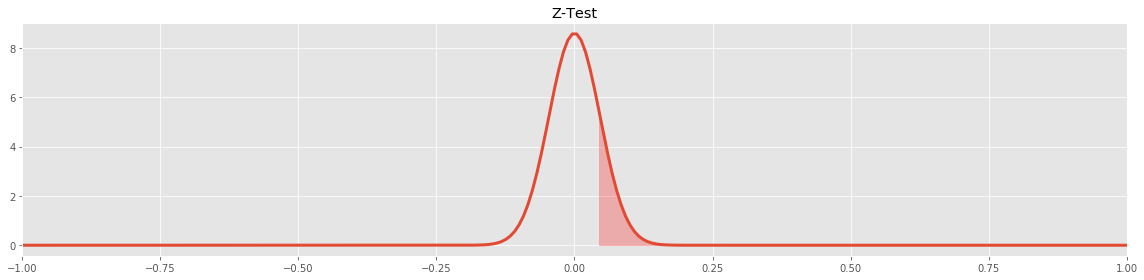

In [28]:
fig, ax = plt.subplots(1, figsize=(16, 4))

x = np.linspace(-1, 1, num=250)
ax.plot(x, diff_in_prop.pdf(x), linewidth=3)
ax.fill_between(x, diff_in_prop.pdf(x), where=(x >= diff_in_sample_prop),
               color='red', alpha=0.25)
ax.set_xlim(-1, 1)
ax.set_title('Z-Test')
plt.tight_layout()

plt.savefig('images/z-test.png')

We will set our level of significance(alpha) relatively high at $\alpha = 0.2$. Since the p-value is greater than alpha, we will fail to reject our null hypothesis. There isn't enough statistical evidence that shows that the toxicity rate in Western skincare products is greater than Korean ones.

**Welch' T-Test**

We're using Welch's T-Test to test if the means of two populations are equal since we have unequal sample sizes.

Our null hypothesis is:
$$ H_0: \ \mu_K = \mu_W $$
$$ H_a: \ \mu_W \geq \mu_K $$

In [20]:
def welch_test_statistic(sample1, sample2):
    numerator = np.mean(sample1) - np.mean(sample2)
    denominator_sq = (np.var(sample1) / len(sample1)) + (np.var(sample2) / len(sample2))
    return numerator / np.sqrt(denominator_sq)

In [21]:
test_stat = welch_test_statistic(sample_kor, sample_west)
print('Welch Test Statistic: {:2.2f}'.format(test_stat))

Welch Test Statistic: -0.17


In [22]:
#use student t-test and calculate degrees of freedom
def welch_satterthwaite_df(sample1, sample2):
    ss1 = len(sample1)
    ss2 = len(sample2)
    df = (
        ((np.var(sample1)/ss1 + np.var(sample2)/ss2)**(2.0)) / 
        ((np.var(sample1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample2)/ss2)**(2.0)/(ss2 - 1))
    )
    return df

In [23]:
df = welch_satterthwaite_df(sample_kor, sample_west)
print("Degrees of Freedom for Welch's Test: {:2.2f}".format(df))

Degrees of Freedom for Welch's Test: 118.29


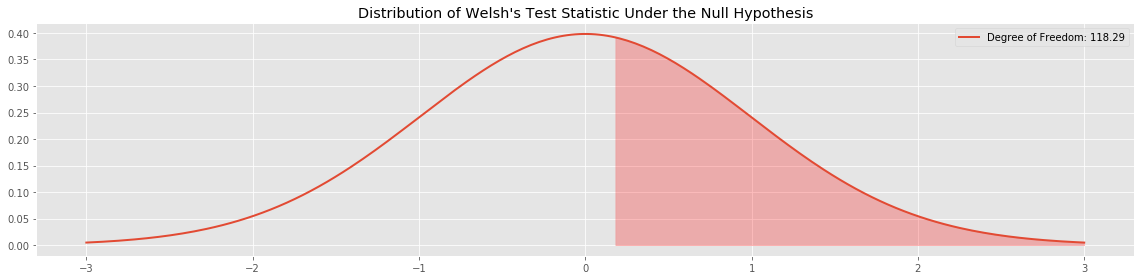

In [29]:
x = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(1, figsize=(16, 4))
students = stats.t(df)
ax.plot(x, students.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(df))
_ = ax.fill_between(x, students.pdf(x), where=(x >= -test_stat), color='red', alpha=0.25)
# _ = ax.fill_between(x, students.pdf(x), where=(x <= test_stat), color='red', alpha=0.25)

ax.legend()
ax.set_title("Distribution of Welsh's Test Statistic Under the Null Hypothesis")
plt.tight_layout()

plt.savefig('images/t-test.png')

In [25]:
p_val = (1 - students.cdf(-test_stat))
print('p-value for different average kickflip height: {:2.2f}'.format(p_val))

p-value for different average kickflip height: 0.43


We will set our level of significance (alpha) relatively high at $\alpha = 0.2$. Since the p-value is greater than alpha, we will fail to reject our null hypothesis. There isn't enough statistical evidence that shows that the toxicity rate in Western skincare products is greater than Korean ones.

**U-Test**

> $H_0$: The number of toxic products in Western skincare products are equaliy likely to be higher than Korean ones as the other way around.  I.e. 
  
  $$P(\text{# of Western toxic products} > \text{# of Korean toxic products}) = 0.5$$

In [72]:
res = stats.mannwhitneyu(sample_west, sample_kor, alternative="greater")
print('p-value for Western > Matt: {:2.2f}'.format(res.pvalue))

p-value for Western > Matt: 0.43


It is safe to assume that we do not have enough statistical evidence to say that Western skincare products have a greater toxicity rate that Korean ones since our p-value from the U-Test is the same as the p-value from our Welch's test.

Going forward, when re-performing this test, it would be beneficial to increase the sample size of the Korean skincare brands and products. This would perhaps change the result of the test.